In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib as plt

In [4]:
df=pd.read_csv("financial fraud.csv")

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [13]:

df.drop(columns='type', axis=1, inplace=True)


In [10]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [14]:
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [30]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,181.00,181.0,0.00,0.0,0.0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1
4,1,11668.14,41554.0,29885.86,0.0,0.0,0


In [37]:
features = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step']
X = df[features].fillna(0)

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Save scaler if needed with joblib/pickle


In [39]:
from sklearn.ensemble import IsolationForest
import joblib

iso = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
iso.fit(X_scaled)
joblib.dump({'iso':iso, 'scaler':scaler, 'features':features}, "models/isoo_model.pkl")



['models/isoo_model.pkl']

In [34]:
import joblib
credit = joblib.load("models/credit_card_model.pkl")  # your model
def compute_supervised_prob(credit_model, df):
    try:
        # if model expects specific features, prepare them; try using amount & category
        Xsup = df[['amount','category_code']].fillna(0)
        probs = credit_model.predict_proba(Xsup)[:,1]
    except Exception:
        # fallback: simple normalized amount score
        probs = (df['amount'] / (df['amount'].max()+1e-9)).clip(0,1)
    return probs

df['supervised_prob'] = compute_supervised_prob(credit, df)


c:\Users\dellll\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [40]:
obj = joblib.load("models/isoo_model.pkl")
iso = obj['iso']; scaler = obj['scaler']; features = obj['features']
X_score = scaler.transform(df[features].fillna(0))
raw = iso.decision_function(X_score)   # higher = more normal
anomaly_prob = (raw.max() - raw) / (raw.max() - raw.min() + 1e-9)  # invert & normalize
df['anomaly_prob'] = anomaly_prob
df['anomaly_flag'] = (iso.predict(X_score) == -1).astype(int)



In [41]:
SUP_WEIGHT = 0.7
df['final_score'] = SUP_WEIGHT * df['supervised_prob'] + (1-SUP_WEIGHT) * df['anomaly_prob']
df['risk_level'] = pd.cut(df['final_score'], bins=[-0.01, 0.3, 0.7, 1.0], labels=['LOW','MEDIUM','HIGH'])


In [42]:
df.loc[df['amount'] > 100000, 'final_score'] = np.minimum(1.0, df['final_score'] + 0.2)


In [43]:
df['sup_pred'] = (df['supervised_prob'] >= 0.5).astype(int)


In [44]:
from sklearn.metrics import accuracy_score, classification_report

print("Supervised Accuracy:", accuracy_score(df['isFraud'], df['sup_pred']))
print(classification_report(df['isFraud'], df['sup_pred']))


Supervised Accuracy: 0.9986969204510092
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.00      0.00      0.00      8213

    accuracy                           1.00   6362620
   macro avg       0.50      0.50      0.50   6362620
weighted avg       1.00      1.00      1.00   6362620



In [45]:
df['anomaly_flag']
print("Anomaly Model Accuracy:", accuracy_score(df['isFraud'], df['anomaly_flag']))
print(classification_report(df['isFraud'], df['anomaly_flag']))


Anomaly Model Accuracy: 0.9790045610141734
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   6354407
           1       0.01      0.11      0.01      8213

    accuracy                           0.98   6362620
   macro avg       0.50      0.55      0.50   6362620
weighted avg       1.00      0.98      0.99   6362620



In [46]:
df['final_pred'] = (df['final_score'] >= 0.5).astype(int)
print("Hybrid Model Accuracy:", accuracy_score(df['isFraud'], df['final_pred']))
print(classification_report(df['isFraud'], df['final_pred']))


Hybrid Model Accuracy: 0.9979190962213679
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.06      0.04      0.05      8213

    accuracy                           1.00   6362620
   macro avg       0.53      0.52      0.52   6362620
weighted avg       1.00      1.00      1.00   6362620



In [47]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Convert final_score into prediction
df['pred'] = (df['final_score'] >= 0.5).astype(int)

# 2. See few predictions
print(df[['final_score','pred','isFraud']].head(20))

# 3. Accuracy
print("Accuracy:", accuracy_score(df['isFraud'], df['pred']))

# 4. Classification Report
print(classification_report(df['isFraud'], df['pred']))

# 5. Confusion Matrix
print(confusion_matrix(df['isFraud'], df['pred']))


    final_score  pred  isFraud
0      0.037036     0        0
1      0.028557     0        0
2      0.029824     0        1
3      0.031975     0        1
4      0.027920     0        0
5      0.029045     0        0
6      0.037560     0        0
7      0.037708     0        0
8      0.027465     0        0
9      0.033648     0        0
10     0.032822     0        0
11     0.028060     0        0
12     0.028421     0        0
13     0.027291     0        0
14     0.058267     0        0
15     0.238933     0        0
16     0.028679     0        0
17     0.028957     0        0
18     0.029442     0        0
19     0.238571     0        0
Accuracy: 0.9979190962213679
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.06      0.04      0.05      8213

    accuracy                           1.00   6362620
   macro avg       0.53      0.52      0.52   6362620
weighted avg       1.00      1.00      1.00   63

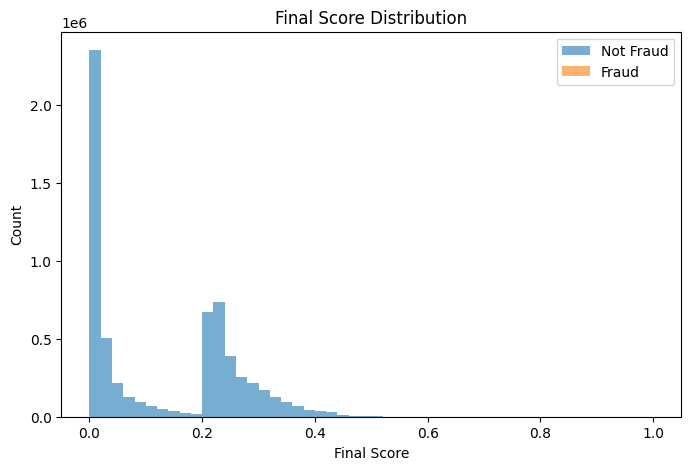

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df[df['isFraud']==0]['final_score'], bins=50, alpha=0.6, label='Not Fraud')
plt.hist(df[df['isFraud']==1]['final_score'], bins=50, alpha=0.6, label='Fraud')

plt.title("Final Score Distribution")
plt.xlabel("Final Score")
plt.ylabel("Count")
plt.legend()
plt.show()


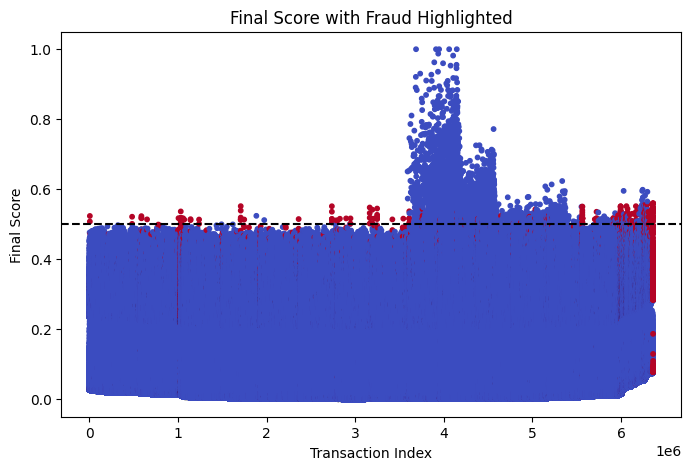

In [49]:
plt.figure(figsize=(8,5))
plt.scatter(df.index, df['final_score'], c=df['isFraud'], cmap='coolwarm', s=10)
plt.axhline(0.5, color='black', linestyle='--')  # threshold line
plt.title("Final Score with Fraud Highlighted")
plt.xlabel("Transaction Index")
plt.ylabel("Final Score")
plt.show()
